In [33]:
import pandas as pd
#import torch
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk
from collections import Counter
import re
# from datasets import load_dataset

In [34]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)
print("Keras available from TensorFlow: ", tf.keras.__name__)  # Should print "tensorflow.keras"
#print(torch.cuda.is_available())

Num GPUs Available:  1
2.2.0
Keras available from TensorFlow:  tensorflow.keras


In [35]:
df_phishing = pd.read_csv('cleaned_phishing_emails.csv')
df_ham = pd.read_csv('cleaned_ham_emails.csv')

# Replace NaN values in the dataframe with empty strings, if any
df_phishing['message'] = df_phishing['message'].fillna('')
df_ham['message'] = df_ham['message'].fillna('')

# Filter the DataFrame to keep only rows where the 'message' length is 10000 characters or shorter
df_filtered = df_phishing[df_phishing['message'].str.len() <= 10000]
df_ham = df_ham[df_ham['message'].str.len() <= 10000]

# Update the original DataFrame if needed
df_phishing = df_filtered

#df_ham = df_ham.sample(n=1992, random_state=42)

print(df_phishing.shape)
print(df_ham.shape)
print(df_phishing.head())
print(df_ham.head())

(2152, 2)
(2471, 2)
                                             message  label
0  Important Security Message You will not see th...      1
1  NEW PDF MESSAGE FROM AMERICAN EXPRESS ONLINE F...      1
2  Confirm Your recent Transactions You will not ...      1
3  =?UTF-8?B?WW91ciBFbWFpbCDinIkg?=jose@monkey.or...      1
4  confirm This Transaction You will not see this...      1
                                             message  label
0  Re: [R] How to solve difficult equations? plot...      0
1  CNN Alerts: bush CNN Alerts: bush Alert Name: ...      0
2  This weeks' component news: $34,000+ in prizes...      0
3  Speech-dispatcher, Festival and Flite Hi, this...      0
4  Information for Napster Napster Stock Quote No...      0


In [37]:
df_combined = pd.concat([df_ham, df_phishing], ignore_index=True)

# Shuffle the combined DataFrame
df = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

msg_label = df['label'].values

In [38]:
x_train, x_test, y_train, y_test = train_test_split(df["message"], msg_label, test_size=0.2, random_state=42)

# To check the distribution in the training and testing sets
print("Training set class distribution:", np.bincount(y_train))
print("Test set class distribution:", np.bincount(y_test))

Training set class distribution: [1963 1735]
Test set class distribution: [508 417]


In [39]:
# Defining pre-processing parameters
max_len = 300 
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # out of vocabulary token
vocab_size = 5000

In [40]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = vocab_size, 
                      char_level = False,
                      oov_token = oov_tok)
tokenizer.fit_on_texts(x_train)

In [41]:
# Get the word_index
word_index = tokenizer.word_index
total_words = len(word_index)
total_words

44985

In [42]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

training_sequences = tokenizer.texts_to_sequences(x_train)
training_padded = pad_sequences(training_sequences,
                                maxlen = max_len,
                                padding = padding_type,
                                truncating = trunc_type)

In [43]:
testing_sequences = tokenizer.texts_to_sequences(x_test)
testing_padded = pad_sequences(testing_sequences,
                               maxlen = max_len,
                               padding = padding_type,
                               truncating = trunc_type)

In [44]:
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (3698, 300)
Shape of testing tensor:  (925, 300)


In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Dropout

embedding_dim = 128
vocab_size = 5001
max_len = 300
drop_lstm = 0.2
n_lstm = 128

# Example LSTM model
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))  # Adjust dimensions as needed
model.add(SpatialDropout1D(drop_lstm))
model.add(LSTM(n_lstm, return_sequences=False))
model.add(Dropout(drop_lstm))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 128)          640128    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 300, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 771,841
Trainable params: 771,841
Non-trainable params: 0
_________________________________________________________________


In [46]:
# Train the model
history = model.fit(training_padded, y_train, epochs=30, validation_data=(testing_padded, y_test), batch_size=32)

Epoch 1/30
116/116 [==============================] - 4s 36ms/step - loss: 0.4754 - accuracy: 0.7653 - val_loss: 0.2363 - val_accuracy: 0.9265
Epoch 2/30
116/116 [==============================] - 4s 33ms/step - loss: 0.1864 - accuracy: 0.9440 - val_loss: 0.1726 - val_accuracy: 0.9535
Epoch 3/30
116/116 [==============================] - 3s 30ms/step - loss: 0.1325 - accuracy: 0.9694 - val_loss: 0.1682 - val_accuracy: 0.9600
Epoch 4/30
116/116 [==============================] - 2s 19ms/step - loss: 0.2931 - accuracy: 0.9067 - val_loss: 0.2723 - val_accuracy: 0.9081
Epoch 5/30
116/116 [==============================] - 3s 28ms/step - loss: 0.2206 - accuracy: 0.9302 - val_loss: 0.1031 - val_accuracy: 0.9741
Epoch 6/30
116/116 [==============================] - 3s 28ms/step - loss: 0.1889 - accuracy: 0.9438 - val_loss: 0.2036 - val_accuracy: 0.9395
Epoch 7/30
116/116 [==============================] - 3s 29ms/step - loss: 0.1934 - accuracy: 0.9448 - val_loss: 0.1869 - val_accuracy: 0.9395

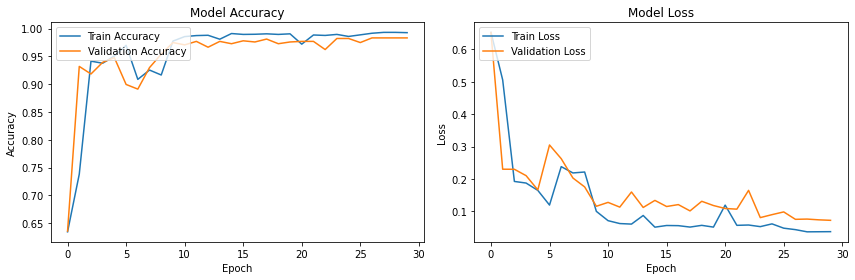

In [14]:
# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

Classificaiton Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       508
           1       0.99      0.98      0.98       417

    accuracy                           0.99       925
   macro avg       0.99      0.99      0.99       925
weighted avg       0.99      0.99      0.99       925

Accuracy: 0.98595
Precision: 0.98637
Recall: 0.98527
F1-score: 0.98579
False Negative Rate: 0.02158


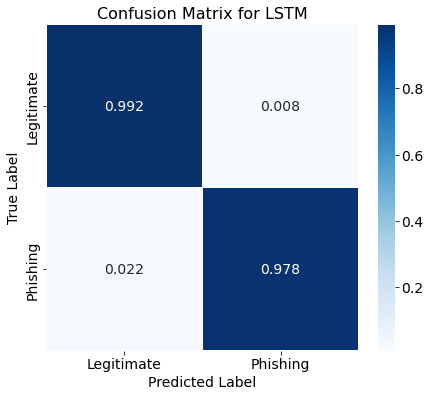

In [47]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

y_pred_probs = model.predict(testing_padded)

# 2. For binary classification, you can threshold at 0.5 to get class predictions
y_pred = (y_pred_probs > 0.5).astype(int)

# 4. Generate the classification report
report = classification_report(y_test, y_pred, digits=2)

# 5. Print the classification report
print("Classificaiton Report:")
print(report)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print the metrics
print(f"Accuracy: {accuracy:.5f}")
print(f"Precision: {precision:.5f}")
print(f"Recall: {recall:.5f}")
print(f"F1-score: {f1:.5f}")

# Calculate the false negative rate
# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# False Negative (FN) is the second row, first column in binary classification
false_negatives = cm[1][0]
# True Positives (TP) is the second row, second column
true_positives = cm[1][1]
# Calculate false negative rate
fn_rate = false_negatives / (false_negatives + true_positives)

# Print the false negative rate
print(f"False Negative Rate: {fn_rate:.5f}")

# Normalize the confusion matrix to percentages
conf_matrix_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(7, 6))
heatmap = sns.heatmap(conf_matrix_percent, annot=True, fmt='.3f', cmap='Blues', cbar=True, linewidths=0.5,
            xticklabels=['Legitimate', 'Phishing'], yticklabels=['Legitimate', 'Phishing'], annot_kws={"size": 14})
ax.set_title(f"Confusion Matrix for LSTM", fontsize=16)
ax.set_xlabel('Predicted Label', fontsize=14)
ax.set_ylabel('True Label', fontsize=14)
plt.xticks(fontsize=14) 
plt.yticks(fontsize=14)
# Modify the color bar
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)  # Increase font size of color bar ticks
plt.show()